In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))
# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_addons as tfa
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
import seaborn as sns

from datetime import datetime

print(tf.__version__)
tf.config.list_physical_devices('GPU')
memory = True
gpus = tf.config.list_physical_devices('GPU')
if gpus and memory:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2.9.1
1 Physical GPUs, 1 Logical GPUs


2022-11-19 13:15:26.170744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 13:15:26.176473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 13:15:26.176846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-19 13:15:26.177659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['sparse_categorical_accuracy']
    val_accuracy = training_history.history['val_sparse_categorical_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.savefig(fname="convoluted/convoluted confusion history"+current_time,dpi=300)

In [3]:
(ds_train, ds_test, ds_validation), ds_info = tfds.load(
    'eurosat/all',
    split=['train[:80%]','train[80%:90%]','train[90%:100%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return image[:,:,0:7]/28002., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

ds_validation = ds_validation.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_validation = ds_validation.batch(128)
ds_validation = ds_validation.cache()

In [5]:
#FLIP
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image
# AUGMENT COLOR
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.07)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image
# ROTATE
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )
#INVERT
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.8:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [6]:
def augment_data(image,label):
  image=augment_flip(image)
  #image=augment_color(image)
  #image=augment_rotation(image)
  image=augment_inversion(image)


  return image,label

In [7]:
ds_train_augmented = ds_train.map(augment_data)

In [8]:
ds_validation_augmented = ds_validation.map(augment_data)

In [9]:
def preview_dataset(dataset):
    for features in dataset.take(20):
        (image, label) = features
        # plt.axis('Off')
        print(np.amax(image.numpy()))
preview_dataset(ds_train_augmented)

0.35615313
0.63727593
0.84019
0.64045423
0.8498679
0.28894365
0.9999643
0.3928291
0.38557962
0.9951432
0.6313835
0.99496466
0.24416113
0.99496466
0.9999286
0.7736233
0.9933576
0.2297693
0.89036494
0.9999286


In [10]:
def balanceofdataset(dataset):
    classes = [0 for i in range(10)]
    for image, label in dataset.unbatch():
        classes[label.numpy()] +=1
        #print(label.numpy())
    print(classes)

#balanceofdataset(ds_train)
#balanceofdataset(ds_train_augmented)
#balanceofdataset(ds_validation)
#balanceofdataset(ds_test)

In [11]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 10:
        return lr * tf.math.exp(-0.1)
    elif epoch < 100:
        return lr * tf.math.exp(-0.01)
    elif epoch < 200:
        return lr * tf.math.exp(-0.005)
    else:
        return lr

In [12]:
image_shape = (64,64,7)
model = tf.keras.models.Sequential([
    tf.keras.layers.Convolution2D(input_shape=image_shape,filters=32,kernel_size=2,strides=(1,1),activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(1,1)),
    tf.keras.layers.Convolution2D(input_shape=image_shape,filters=32,kernel_size=2,strides=(1,1),activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Convolution2D(input_shape=image_shape,filters=64,kernel_size=3,strides=(1,1),activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(1,1)),
    tf.keras.layers.Convolution2D(input_shape=image_shape,filters=128,kernel_size=3,strides=(2,2),activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


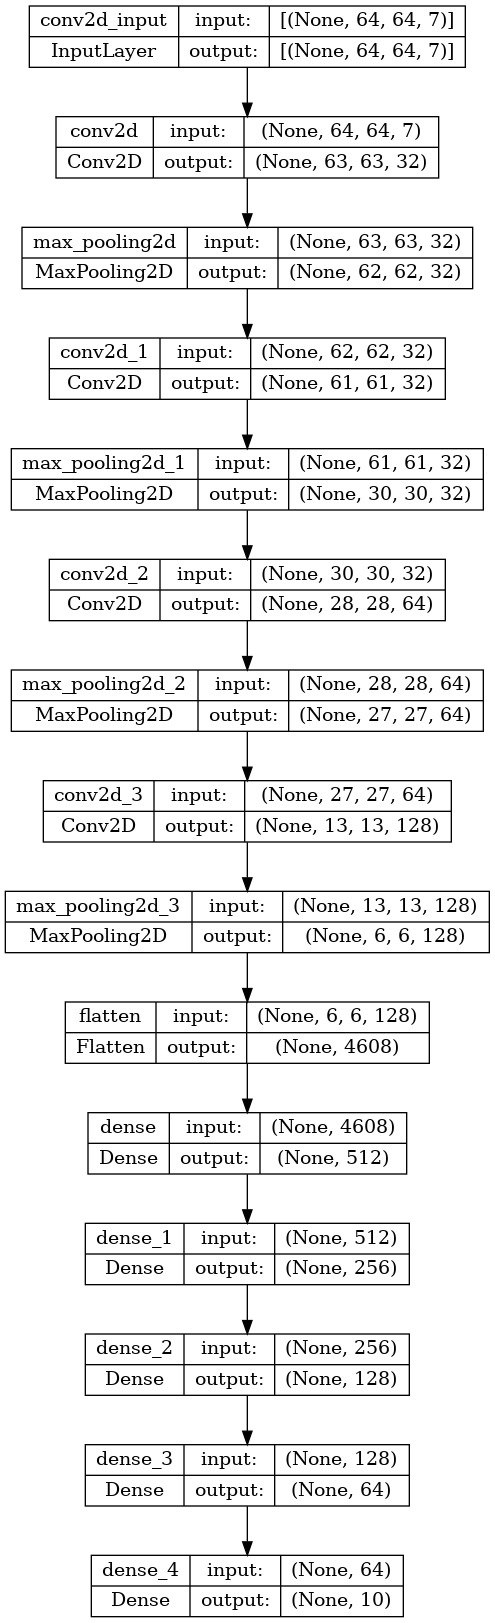

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00012),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [14]:
history = model.fit(
    ds_train,
    epochs=800,
    validation_data=ds_validation,
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
        "convoluted/convoluted epoch:{epoch:02d}-val_loss:{val_loss:.3f}",
        save_best_only = True,
        initial_value_threshold = 0.3
    )
    ,tf.keras.callbacks.LearningRateScheduler(scheduler)
    ]
)

Epoch 1/800


2022-11-19 13:15:30.184897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


169/169 [==============================] - 8s 39ms/step - loss: 1.6144 - sparse_categorical_accuracy: 0.3971 - val_loss: 1.1144 - val_sparse_categorical_accuracy: 0.5770 - lr: 1.2000e-04
Epoch 2/800
169/169 [==============================] - 6s 35ms/step - loss: 1.0359 - sparse_categorical_accuracy: 0.6067 - val_loss: 0.9344 - val_sparse_categorical_accuracy: 0.6296 - lr: 1.2000e-04
Epoch 3/800
169/169 [==============================] - 6s 36ms/step - loss: 0.8738 - sparse_categorical_accuracy: 0.6700 - val_loss: 0.8354 - val_sparse_categorical_accuracy: 0.6837 - lr: 1.2000e-04
Epoch 4/800
169/169 [==============================] - 6s 36ms/step - loss: 0.7752 - sparse_categorical_accuracy: 0.7108 - val_loss: 0.7362 - val_sparse_categorical_accuracy: 0.7370 - lr: 1.2000e-04
Epoch 5/800
169/169 [==============================] - 6s 36ms/step - loss: 0.7032 - sparse_categorical_accuracy: 0.7422 - val_loss: 0.6671 - val_sparse_categorical_accuracy: 0.7574 - lr: 1.2000e-04
Epoch 6/800
169/1

169/169 [==============================] - 6s 36ms/step - loss: 0.3079 - sparse_categorical_accuracy: 0.8909 - val_loss: 0.3390 - val_sparse_categorical_accuracy: 0.8837 - lr: 5.2852e-05
Epoch 43/800
169/169 [==============================] - 6s 36ms/step - loss: 0.3043 - sparse_categorical_accuracy: 0.8933 - val_loss: 0.3225 - val_sparse_categorical_accuracy: 0.8896 - lr: 5.2326e-05
Epoch 44/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2972 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.3120 - val_sparse_categorical_accuracy: 0.8930 - lr: 5.1805e-05
Epoch 45/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2865 - sparse_categorical_accuracy: 0.8989 - val_loss: 0.3475 - val_sparse_categorical_accuracy: 0.8741 - lr: 5.1290e-05
Epoch 46/800
169/169 [==============================] - ETA: 0s - loss: 0.2910 - sparse_categorical_accuracy: 0.8966

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:46-val_loss:0.300/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:46-val_loss:0.300/assets


169/169 [==============================] - 7s 42ms/step - loss: 0.2910 - sparse_categorical_accuracy: 0.8966 - val_loss: 0.2996 - val_sparse_categorical_accuracy: 0.8959 - lr: 5.0779e-05
Epoch 47/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2930 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.3147 - val_sparse_categorical_accuracy: 0.8885 - lr: 5.0274e-05
Epoch 48/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2905 - sparse_categorical_accuracy: 0.8991 - val_loss: 0.3098 - val_sparse_categorical_accuracy: 0.8930 - lr: 4.9774e-05
Epoch 49/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2824 - sparse_categorical_accuracy: 0.8990 - val_loss: 0.3059 - val_sparse_categorical_accuracy: 0.8959 - lr: 4.9279e-05
Epoch 50/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2754 - sparse_categorical_accuracy: 0.9029 - val_loss: 0.3029 - val_sparse_categorical_accuracy: 0.8919 - lr: 4.8788e-05
Epoch 51/800


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:55-val_loss:0.292/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:55-val_loss:0.292/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.2725 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.2922 - val_sparse_categorical_accuracy: 0.8985 - lr: 4.6409e-05
Epoch 56/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2658 - sparse_categorical_accuracy: 0.9070 - val_loss: 0.2964 - val_sparse_categorical_accuracy: 0.9011 - lr: 4.5947e-05
Epoch 57/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2595 - sparse_categorical_accuracy: 0.9102 - val_loss: 0.2977 - val_sparse_categorical_accuracy: 0.8948 - lr: 4.5490e-05
Epoch 58/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2605 - sparse_categorical_accuracy: 0.9087 - val_loss: 0.3234 - val_sparse_categorical_accuracy: 0.8889 - lr: 4.5037e-05
Epoch 59/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2580 - sparse_categorical_accuracy: 0.9093 - val_loss: 0.2952 - val_sparse_categorical_accuracy: 0.8941 - lr: 4.4589e-05
Epoch 60/800


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:62-val_loss:0.289/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:62-val_loss:0.289/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.2574 - sparse_categorical_accuracy: 0.9092 - val_loss: 0.2894 - val_sparse_categorical_accuracy: 0.8959 - lr: 4.3271e-05
Epoch 63/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2496 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.3387 - val_sparse_categorical_accuracy: 0.8793 - lr: 4.2841e-05
Epoch 64/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2553 - sparse_categorical_accuracy: 0.9099 - val_loss: 0.3043 - val_sparse_categorical_accuracy: 0.8952 - lr: 4.2415e-05
Epoch 65/800
169/169 [==============================] - ETA: 0s - loss: 0.2459 - sparse_categorical_accuracy: 0.9143

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:65-val_loss:0.286/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:65-val_loss:0.286/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.2459 - sparse_categorical_accuracy: 0.9143 - val_loss: 0.2861 - val_sparse_categorical_accuracy: 0.8993 - lr: 4.1993e-05
Epoch 66/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2413 - sparse_categorical_accuracy: 0.9157 - val_loss: 0.2909 - val_sparse_categorical_accuracy: 0.9004 - lr: 4.1575e-05
Epoch 67/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2457 - sparse_categorical_accuracy: 0.9133 - val_loss: 0.3064 - val_sparse_categorical_accuracy: 0.8952 - lr: 4.1161e-05
Epoch 68/800
169/169 [==============================] - ETA: 0s - loss: 0.2391 - sparse_categorical_accuracy: 0.9173

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:68-val_loss:0.276/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:68-val_loss:0.276/assets


169/169 [==============================] - 7s 42ms/step - loss: 0.2391 - sparse_categorical_accuracy: 0.9173 - val_loss: 0.2763 - val_sparse_categorical_accuracy: 0.9056 - lr: 4.0751e-05
Epoch 69/800
169/169 [==============================] - ETA: 0s - loss: 0.2400 - sparse_categorical_accuracy: 0.9156

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:69-val_loss:0.273/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:69-val_loss:0.273/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.2400 - sparse_categorical_accuracy: 0.9156 - val_loss: 0.2733 - val_sparse_categorical_accuracy: 0.9093 - lr: 4.0346e-05
Epoch 70/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2332 - sparse_categorical_accuracy: 0.9193 - val_loss: 0.2813 - val_sparse_categorical_accuracy: 0.9015 - lr: 3.9945e-05
Epoch 71/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2413 - sparse_categorical_accuracy: 0.9141 - val_loss: 0.2802 - val_sparse_categorical_accuracy: 0.9000 - lr: 3.9547e-05
Epoch 72/800
169/169 [==============================] - ETA: 0s - loss: 0.2284 - sparse_categorical_accuracy: 0.9206

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:72-val_loss:0.267/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:72-val_loss:0.267/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.2284 - sparse_categorical_accuracy: 0.9206 - val_loss: 0.2674 - val_sparse_categorical_accuracy: 0.9096 - lr: 3.9154e-05
Epoch 73/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2315 - sparse_categorical_accuracy: 0.9189 - val_loss: 0.2722 - val_sparse_categorical_accuracy: 0.9070 - lr: 3.8764e-05
Epoch 74/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2277 - sparse_categorical_accuracy: 0.9211 - val_loss: 0.2918 - val_sparse_categorical_accuracy: 0.8989 - lr: 3.8378e-05
Epoch 75/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2249 - sparse_categorical_accuracy: 0.9238 - val_loss: 0.2963 - val_sparse_categorical_accuracy: 0.9004 - lr: 3.7996e-05
Epoch 76/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2232 - sparse_categorical_accuracy: 0.9223 - val_loss: 0.2902 - val_sparse_categorical_accuracy: 0.8944 - lr: 3.7618e-05
Epoch 77/800


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:79-val_loss:0.267/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:79-val_loss:0.267/assets


169/169 [==============================] - 7s 40ms/step - loss: 0.2243 - sparse_categorical_accuracy: 0.9218 - val_loss: 0.2671 - val_sparse_categorical_accuracy: 0.9093 - lr: 3.6507e-05
Epoch 80/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2171 - sparse_categorical_accuracy: 0.9243 - val_loss: 0.2702 - val_sparse_categorical_accuracy: 0.9063 - lr: 3.6143e-05
Epoch 81/800
169/169 [==============================] - ETA: 0s - loss: 0.2182 - sparse_categorical_accuracy: 0.9237

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:81-val_loss:0.262/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:81-val_loss:0.262/assets


169/169 [==============================] - 7s 42ms/step - loss: 0.2182 - sparse_categorical_accuracy: 0.9237 - val_loss: 0.2621 - val_sparse_categorical_accuracy: 0.9111 - lr: 3.5784e-05
Epoch 82/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2134 - sparse_categorical_accuracy: 0.9278 - val_loss: 0.2653 - val_sparse_categorical_accuracy: 0.9059 - lr: 3.5428e-05
Epoch 83/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2090 - sparse_categorical_accuracy: 0.9269 - val_loss: 0.2737 - val_sparse_categorical_accuracy: 0.9052 - lr: 3.5075e-05
Epoch 84/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2076 - sparse_categorical_accuracy: 0.9297 - val_loss: 0.2660 - val_sparse_categorical_accuracy: 0.9115 - lr: 3.4726e-05
Epoch 85/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2125 - sparse_categorical_accuracy: 0.9267 - val_loss: 0.2647 - val_sparse_categorical_accuracy: 0.9056 - lr: 3.4381e-05
Epoch 86/800


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:89-val_loss:0.256/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:89-val_loss:0.256/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.2031 - sparse_categorical_accuracy: 0.9301 - val_loss: 0.2558 - val_sparse_categorical_accuracy: 0.9170 - lr: 3.3032e-05
Epoch 90/800
169/169 [==============================] - 6s 36ms/step - loss: 0.2039 - sparse_categorical_accuracy: 0.9288 - val_loss: 0.2974 - val_sparse_categorical_accuracy: 0.8974 - lr: 3.2704e-05
Epoch 91/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1986 - sparse_categorical_accuracy: 0.9310 - val_loss: 0.2740 - val_sparse_categorical_accuracy: 0.9030 - lr: 3.2378e-05
Epoch 92/800
169/169 [==============================] - ETA: 0s - loss: 0.2001 - sparse_categorical_accuracy: 0.9299

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:92-val_loss:0.252/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:92-val_loss:0.252/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.2001 - sparse_categorical_accuracy: 0.9299 - val_loss: 0.2519 - val_sparse_categorical_accuracy: 0.9137 - lr: 3.2056e-05
Epoch 93/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1962 - sparse_categorical_accuracy: 0.9323 - val_loss: 0.2567 - val_sparse_categorical_accuracy: 0.9152 - lr: 3.1737e-05
Epoch 94/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1951 - sparse_categorical_accuracy: 0.9329 - val_loss: 0.2544 - val_sparse_categorical_accuracy: 0.9137 - lr: 3.1421e-05
Epoch 95/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1913 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.2704 - val_sparse_categorical_accuracy: 0.9074 - lr: 3.1109e-05
Epoch 96/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1889 - sparse_categorical_accuracy: 0.9347 - val_loss: 0.2569 - val_sparse_categorical_accuracy: 0.9163 - lr: 3.0799e-05
Epoch 97/800


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:102-val_loss:0.251/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:102-val_loss:0.251/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.1815 - sparse_categorical_accuracy: 0.9369 - val_loss: 0.2507 - val_sparse_categorical_accuracy: 0.9174 - lr: 2.9297e-05
Epoch 103/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1846 - sparse_categorical_accuracy: 0.9361 - val_loss: 0.2738 - val_sparse_categorical_accuracy: 0.9074 - lr: 2.9151e-05
Epoch 104/800
169/169 [==============================] - ETA: 0s - loss: 0.1781 - sparse_categorical_accuracy: 0.9392

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:104-val_loss:0.250/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:104-val_loss:0.250/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.1781 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.2505 - val_sparse_categorical_accuracy: 0.9148 - lr: 2.9006e-05
Epoch 105/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1803 - sparse_categorical_accuracy: 0.9395 - val_loss: 0.2558 - val_sparse_categorical_accuracy: 0.9126 - lr: 2.8861e-05
Epoch 106/800
169/169 [==============================] - ETA: 0s - loss: 0.1779 - sparse_categorical_accuracy: 0.9387

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:106-val_loss:0.245/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:106-val_loss:0.245/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.1779 - sparse_categorical_accuracy: 0.9387 - val_loss: 0.2454 - val_sparse_categorical_accuracy: 0.9196 - lr: 2.8717e-05
Epoch 107/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1784 - sparse_categorical_accuracy: 0.9384 - val_loss: 0.2481 - val_sparse_categorical_accuracy: 0.9193 - lr: 2.8574e-05
Epoch 108/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1741 - sparse_categorical_accuracy: 0.9402 - val_loss: 0.2528 - val_sparse_categorical_accuracy: 0.9115 - lr: 2.8431e-05
Epoch 109/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1738 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.2511 - val_sparse_categorical_accuracy: 0.9200 - lr: 2.8290e-05
Epoch 110/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1753 - sparse_categorical_accuracy: 0.9399 - val_loss: 0.2565 - val_sparse_categorical_accuracy: 0.9152 - lr: 2.8148e-05
Epoch 111

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:112-val_loss:0.241/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:112-val_loss:0.241/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.1667 - sparse_categorical_accuracy: 0.9442 - val_loss: 0.2410 - val_sparse_categorical_accuracy: 0.9230 - lr: 2.7868e-05
Epoch 113/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1704 - sparse_categorical_accuracy: 0.9419 - val_loss: 0.2494 - val_sparse_categorical_accuracy: 0.9178 - lr: 2.7729e-05
Epoch 114/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1643 - sparse_categorical_accuracy: 0.9435 - val_loss: 0.2475 - val_sparse_categorical_accuracy: 0.9178 - lr: 2.7591e-05
Epoch 115/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1651 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.2618 - val_sparse_categorical_accuracy: 0.9081 - lr: 2.7453e-05
Epoch 116/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1678 - sparse_categorical_accuracy: 0.9426 - val_loss: 0.2536 - val_sparse_categorical_accuracy: 0.9130 - lr: 2.7317e-05
Epoch 117

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:126-val_loss:0.240/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:126-val_loss:0.240/assets


169/169 [==============================] - 7s 42ms/step - loss: 0.1531 - sparse_categorical_accuracy: 0.9471 - val_loss: 0.2402 - val_sparse_categorical_accuracy: 0.9222 - lr: 2.5984e-05
Epoch 127/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1540 - sparse_categorical_accuracy: 0.9472 - val_loss: 0.2403 - val_sparse_categorical_accuracy: 0.9219 - lr: 2.5855e-05
Epoch 128/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1515 - sparse_categorical_accuracy: 0.9481 - val_loss: 0.2622 - val_sparse_categorical_accuracy: 0.9141 - lr: 2.5726e-05
Epoch 129/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1542 - sparse_categorical_accuracy: 0.9476 - val_loss: 0.2417 - val_sparse_categorical_accuracy: 0.9222 - lr: 2.5597e-05
Epoch 130/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.9492 - val_loss: 0.2430 - val_sparse_categorical_accuracy: 0.9200 - lr: 2.5470e-05
Epoch 131

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:139-val_loss:0.236/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:139-val_loss:0.236/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9511 - val_loss: 0.2359 - val_sparse_categorical_accuracy: 0.9204 - lr: 2.4349e-05
Epoch 140/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.2496 - val_sparse_categorical_accuracy: 0.9130 - lr: 2.4228e-05
Epoch 141/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1382 - sparse_categorical_accuracy: 0.9546 - val_loss: 0.2408 - val_sparse_categorical_accuracy: 0.9230 - lr: 2.4107e-05
Epoch 142/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1436 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.2504 - val_sparse_categorical_accuracy: 0.9193 - lr: 2.3987e-05
Epoch 143/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1378 - sparse_categorical_accuracy: 0.9534 - val_loss: 0.2544 - val_sparse_categorical_accuracy: 0.9178 - lr: 2.3867e-05
Epoch 144

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:145-val_loss:0.236/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:145-val_loss:0.236/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.1405 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.2357 - val_sparse_categorical_accuracy: 0.9233 - lr: 2.3629e-05
Epoch 146/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1350 - sparse_categorical_accuracy: 0.9534 - val_loss: 0.2549 - val_sparse_categorical_accuracy: 0.9178 - lr: 2.3512e-05
Epoch 147/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1402 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.2420 - val_sparse_categorical_accuracy: 0.9215 - lr: 2.3394e-05
Epoch 148/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.9568 - val_loss: 0.2471 - val_sparse_categorical_accuracy: 0.9200 - lr: 2.3278e-05
Epoch 149/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1362 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.2411 - val_sparse_categorical_accuracy: 0.9207 - lr: 2.3162e-05
Epoch 150

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:154-val_loss:0.233/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:154-val_loss:0.233/assets


169/169 [==============================] - 7s 42ms/step - loss: 0.1352 - sparse_categorical_accuracy: 0.9544 - val_loss: 0.2332 - val_sparse_categorical_accuracy: 0.9233 - lr: 2.2590e-05
Epoch 155/800
169/169 [==============================] - ETA: 0s - loss: 0.1317 - sparse_categorical_accuracy: 0.9559

INFO:tensorflow:Assets written to: convoluted/convoluted epoch:155-val_loss:0.231/assets


INFO:tensorflow:Assets written to: convoluted/convoluted epoch:155-val_loss:0.231/assets


169/169 [==============================] - 7s 41ms/step - loss: 0.1317 - sparse_categorical_accuracy: 0.9559 - val_loss: 0.2314 - val_sparse_categorical_accuracy: 0.9248 - lr: 2.2477e-05
Epoch 156/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1389 - sparse_categorical_accuracy: 0.9523 - val_loss: 0.2423 - val_sparse_categorical_accuracy: 0.9189 - lr: 2.2365e-05
Epoch 157/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.9560 - val_loss: 0.2379 - val_sparse_categorical_accuracy: 0.9252 - lr: 2.2253e-05
Epoch 158/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1327 - sparse_categorical_accuracy: 0.9537 - val_loss: 0.2481 - val_sparse_categorical_accuracy: 0.9196 - lr: 2.2142e-05
Epoch 159/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1284 - sparse_categorical_accuracy: 0.9563 - val_loss: 0.2363 - val_sparse_categorical_accuracy: 0.9219 - lr: 2.2032e-05
Epoch 160

Epoch 196/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.9655 - val_loss: 0.2453 - val_sparse_categorical_accuracy: 0.9237 - lr: 1.8311e-05
Epoch 197/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1032 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.2428 - val_sparse_categorical_accuracy: 0.9241 - lr: 1.8220e-05
Epoch 198/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1038 - sparse_categorical_accuracy: 0.9660 - val_loss: 0.2695 - val_sparse_categorical_accuracy: 0.9185 - lr: 1.8129e-05
Epoch 199/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1046 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.2416 - val_sparse_categorical_accuracy: 0.9263 - lr: 1.8038e-05
Epoch 200/800
169/169 [==============================] - 6s 36ms/step - loss: 0.1027 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.2617 - val_sparse_categorical_accuracy: 0.9178 - lr: 1.7948

Epoch 237/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0864 - sparse_categorical_accuracy: 0.9723 - val_loss: 0.2618 - val_sparse_categorical_accuracy: 0.9230 - lr: 1.7948e-05
Epoch 238/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0886 - sparse_categorical_accuracy: 0.9715 - val_loss: 0.2443 - val_sparse_categorical_accuracy: 0.9293 - lr: 1.7948e-05
Epoch 239/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0835 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.2474 - val_sparse_categorical_accuracy: 0.9296 - lr: 1.7948e-05
Epoch 240/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0836 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.2585 - val_sparse_categorical_accuracy: 0.9215 - lr: 1.7948e-05
Epoch 241/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0838 - sparse_categorical_accuracy: 0.9737 - val_loss: 0.2593 - val_sparse_categorical_accuracy: 0.9252 - lr: 1.7948

Epoch 278/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0710 - sparse_categorical_accuracy: 0.9780 - val_loss: 0.2640 - val_sparse_categorical_accuracy: 0.9267 - lr: 1.7948e-05
Epoch 279/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0709 - sparse_categorical_accuracy: 0.9779 - val_loss: 0.2616 - val_sparse_categorical_accuracy: 0.9267 - lr: 1.7948e-05
Epoch 280/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0756 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.2562 - val_sparse_categorical_accuracy: 0.9270 - lr: 1.7948e-05
Epoch 281/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0732 - sparse_categorical_accuracy: 0.9760 - val_loss: 0.2667 - val_sparse_categorical_accuracy: 0.9241 - lr: 1.7948e-05
Epoch 282/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0677 - sparse_categorical_accuracy: 0.9790 - val_loss: 0.2596 - val_sparse_categorical_accuracy: 0.9259 - lr: 1.7948

Epoch 319/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0578 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.2682 - val_sparse_categorical_accuracy: 0.9300 - lr: 1.7948e-05
Epoch 320/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0624 - sparse_categorical_accuracy: 0.9803 - val_loss: 0.3036 - val_sparse_categorical_accuracy: 0.9226 - lr: 1.7948e-05
Epoch 321/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0593 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.2740 - val_sparse_categorical_accuracy: 0.9296 - lr: 1.7948e-05
Epoch 322/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0582 - sparse_categorical_accuracy: 0.9819 - val_loss: 0.2788 - val_sparse_categorical_accuracy: 0.9281 - lr: 1.7948e-05
Epoch 323/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0590 - sparse_categorical_accuracy: 0.9812 - val_loss: 0.2869 - val_sparse_categorical_accuracy: 0.9244 - lr: 1.7948

Epoch 360/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0479 - sparse_categorical_accuracy: 0.9854 - val_loss: 0.2927 - val_sparse_categorical_accuracy: 0.9293 - lr: 1.7948e-05
Epoch 361/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0459 - sparse_categorical_accuracy: 0.9860 - val_loss: 0.2959 - val_sparse_categorical_accuracy: 0.9293 - lr: 1.7948e-05
Epoch 362/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0469 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.2981 - val_sparse_categorical_accuracy: 0.9270 - lr: 1.7948e-05
Epoch 363/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0520 - sparse_categorical_accuracy: 0.9838 - val_loss: 0.2910 - val_sparse_categorical_accuracy: 0.9337 - lr: 1.7948e-05
Epoch 364/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9861 - val_loss: 0.2974 - val_sparse_categorical_accuracy: 0.9315 - lr: 1.7948

Epoch 401/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0387 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.3259 - val_sparse_categorical_accuracy: 0.9252 - lr: 1.7948e-05
Epoch 402/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0374 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.3245 - val_sparse_categorical_accuracy: 0.9248 - lr: 1.7948e-05
Epoch 403/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9884 - val_loss: 0.3258 - val_sparse_categorical_accuracy: 0.9259 - lr: 1.7948e-05
Epoch 404/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0373 - sparse_categorical_accuracy: 0.9887 - val_loss: 0.3151 - val_sparse_categorical_accuracy: 0.9270 - lr: 1.7948e-05
Epoch 405/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0355 - sparse_categorical_accuracy: 0.9906 - val_loss: 0.3148 - val_sparse_categorical_accuracy: 0.9300 - lr: 1.7948

Epoch 442/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0306 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.3426 - val_sparse_categorical_accuracy: 0.9300 - lr: 1.7948e-05
Epoch 443/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.3358 - val_sparse_categorical_accuracy: 0.9300 - lr: 1.7948e-05
Epoch 444/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0340 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.3410 - val_sparse_categorical_accuracy: 0.9252 - lr: 1.7948e-05
Epoch 445/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0305 - sparse_categorical_accuracy: 0.9909 - val_loss: 0.3450 - val_sparse_categorical_accuracy: 0.9241 - lr: 1.7948e-05
Epoch 446/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.3373 - val_sparse_categorical_accuracy: 0.9256 - lr: 1.7948

Epoch 483/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0254 - sparse_categorical_accuracy: 0.9930 - val_loss: 0.3621 - val_sparse_categorical_accuracy: 0.9281 - lr: 1.7948e-05
Epoch 484/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0221 - sparse_categorical_accuracy: 0.9946 - val_loss: 0.3681 - val_sparse_categorical_accuracy: 0.9285 - lr: 1.7948e-05
Epoch 485/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0207 - sparse_categorical_accuracy: 0.9950 - val_loss: 0.3573 - val_sparse_categorical_accuracy: 0.9256 - lr: 1.7948e-05
Epoch 486/800
169/169 [==============================] - 6s 35ms/step - loss: 0.0219 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.4052 - val_sparse_categorical_accuracy: 0.9219 - lr: 1.7948e-05
Epoch 487/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0317 - sparse_categorical_accuracy: 0.9900 - val_loss: 0.3677 - val_sparse_categorical_accuracy: 0.9289 - lr: 1.7948

Epoch 524/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0202 - sparse_categorical_accuracy: 0.9942 - val_loss: 0.3894 - val_sparse_categorical_accuracy: 0.9270 - lr: 1.7948e-05
Epoch 525/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0154 - sparse_categorical_accuracy: 0.9968 - val_loss: 0.3957 - val_sparse_categorical_accuracy: 0.9300 - lr: 1.7948e-05
Epoch 526/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0231 - sparse_categorical_accuracy: 0.9931 - val_loss: 0.4024 - val_sparse_categorical_accuracy: 0.9248 - lr: 1.7948e-05
Epoch 527/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0150 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.4065 - val_sparse_categorical_accuracy: 0.9252 - lr: 1.7948e-05
Epoch 528/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0153 - sparse_categorical_accuracy: 0.9967 - val_loss: 0.4043 - val_sparse_categorical_accuracy: 0.9259 - lr: 1.7948

Epoch 565/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0125 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.4232 - val_sparse_categorical_accuracy: 0.9274 - lr: 1.7948e-05
Epoch 566/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0128 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.4333 - val_sparse_categorical_accuracy: 0.9285 - lr: 1.7948e-05
Epoch 567/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.4235 - val_sparse_categorical_accuracy: 0.9241 - lr: 1.7948e-05
Epoch 568/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0107 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.4404 - val_sparse_categorical_accuracy: 0.9267 - lr: 1.7948e-05
Epoch 569/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0155 - sparse_categorical_accuracy: 0.9960 - val_loss: 0.4328 - val_sparse_categorical_accuracy: 0.9241 - lr: 1.7948

Epoch 606/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0114 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.4533 - val_sparse_categorical_accuracy: 0.9263 - lr: 1.7948e-05
Epoch 607/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0336 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4637 - val_sparse_categorical_accuracy: 0.9233 - lr: 1.7948e-05
Epoch 608/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0094 - sparse_categorical_accuracy: 0.9985 - val_loss: 0.4368 - val_sparse_categorical_accuracy: 0.9263 - lr: 1.7948e-05
Epoch 609/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0077 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.4463 - val_sparse_categorical_accuracy: 0.9237 - lr: 1.7948e-05
Epoch 610/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0108 - sparse_categorical_accuracy: 0.9974 - val_loss: 0.4415 - val_sparse_categorical_accuracy: 0.9252 - lr: 1.7948

Epoch 647/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.4703 - val_sparse_categorical_accuracy: 0.9222 - lr: 1.7948e-05
Epoch 648/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0070 - sparse_categorical_accuracy: 0.9989 - val_loss: 0.4780 - val_sparse_categorical_accuracy: 0.9252 - lr: 1.7948e-05
Epoch 649/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0085 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.4826 - val_sparse_categorical_accuracy: 0.9237 - lr: 1.7948e-05
Epoch 650/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9988 - val_loss: 0.4719 - val_sparse_categorical_accuracy: 0.9256 - lr: 1.7948e-05
Epoch 651/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.5120 - val_sparse_categorical_accuracy: 0.9200 - lr: 1.7948

Epoch 688/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0039 - sparse_categorical_accuracy: 0.9997 - val_loss: 0.4950 - val_sparse_categorical_accuracy: 0.9215 - lr: 1.7948e-05
Epoch 689/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0100 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.5023 - val_sparse_categorical_accuracy: 0.9233 - lr: 1.7948e-05
Epoch 690/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0075 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.5138 - val_sparse_categorical_accuracy: 0.9219 - lr: 1.7948e-05
Epoch 691/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.5125 - val_sparse_categorical_accuracy: 0.9230 - lr: 1.7948e-05
Epoch 692/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0099 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.4977 - val_sparse_categorical_accuracy: 0.9259 - lr: 1.7948

Epoch 729/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0051 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.5264 - val_sparse_categorical_accuracy: 0.9233 - lr: 1.7948e-05
Epoch 730/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0080 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.5480 - val_sparse_categorical_accuracy: 0.9215 - lr: 1.7948e-05
Epoch 731/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0051 - sparse_categorical_accuracy: 0.9992 - val_loss: 0.5155 - val_sparse_categorical_accuracy: 0.9219 - lr: 1.7948e-05
Epoch 732/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0228 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.5379 - val_sparse_categorical_accuracy: 0.9196 - lr: 1.7948e-05
Epoch 733/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0049 - sparse_categorical_accuracy: 0.9991 - val_loss: 0.5024 - val_sparse_categorical_accuracy: 0.9252 - lr: 1.7948

Epoch 770/800
169/169 [==============================] - 6s 36ms/step - loss: 0.0165 - sparse_categorical_accuracy: 0.9947 - val_loss: 0.5438 - val_sparse_categorical_accuracy: 0.9189 - lr: 1.7948e-05
Epoch 771/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0023 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.5204 - val_sparse_categorical_accuracy: 0.9230 - lr: 1.7948e-05
Epoch 772/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0019 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.5230 - val_sparse_categorical_accuracy: 0.9248 - lr: 1.7948e-05
Epoch 773/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0019 - sparse_categorical_accuracy: 0.9999 - val_loss: 0.5242 - val_sparse_categorical_accuracy: 0.9237 - lr: 1.7948e-05
Epoch 774/800
169/169 [==============================] - 6s 37ms/step - loss: 0.0023 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.5323 - val_sparse_categorical_accuracy: 0.9219 - lr: 1.7948


Test accuracy: 0.9344444274902344


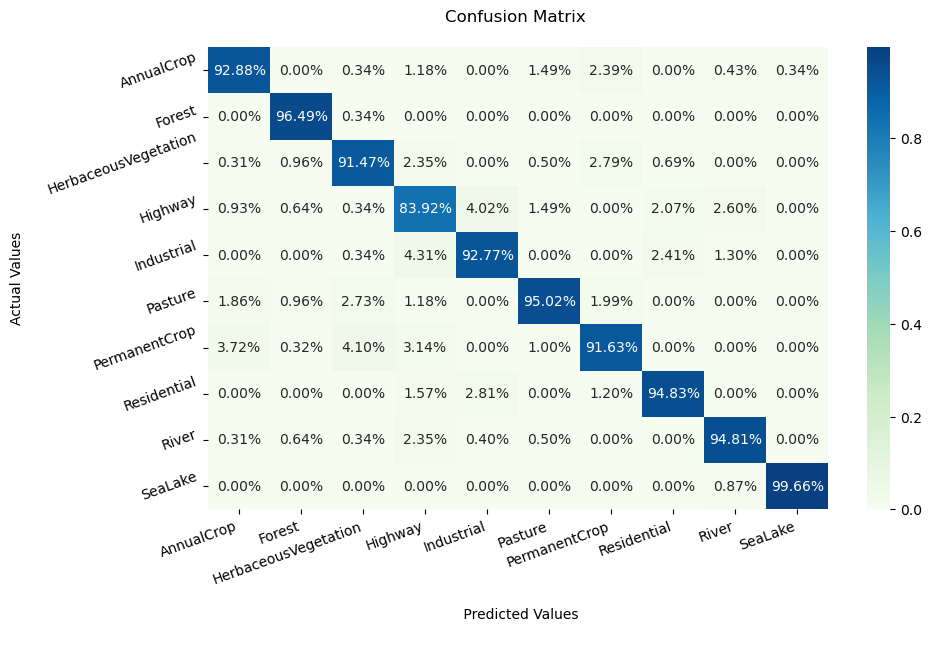

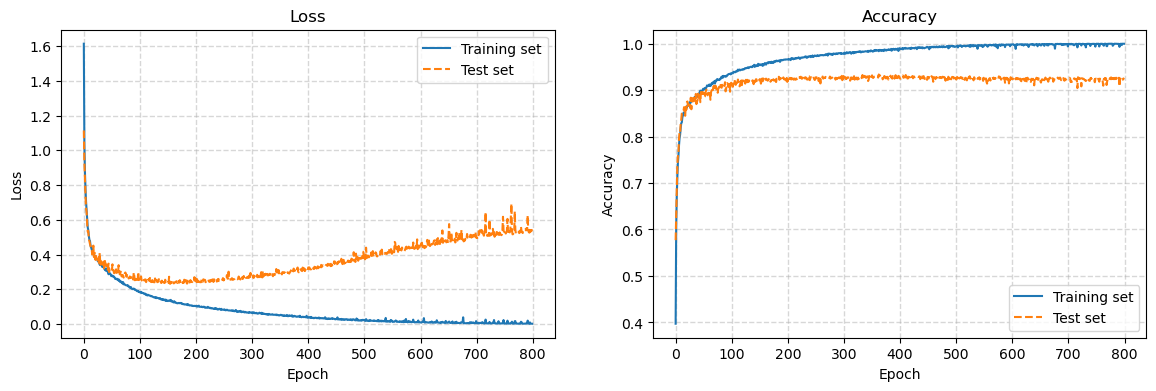

In [15]:
test_loss, test_acc = model.evaluate(ds_test, verbose=0)
print('\nTest accuracy:', test_acc)


ds_test_predict = model.predict(ds_test, verbose=0)

labels_iterator = ds_test.unbatch().map(lambda x, y: y).as_numpy_iterator()
labels = np.array(list(labels_iterator))

y_pred = np.argmax(ds_test_predict, axis=1)
y_test = labels
plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_pred, y_test, normalize="pred"), annot=True, fmt=".2%",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")
fx.yaxis.set_ticklabels(['AnnualCrop','Forest','HerbaceousVegetation',
                         'Highway','Industrial','Pasture','PermanentCrop',
                         'Residential','River','SeaLake'], rotation=20, ha="right")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
plt.savefig(fname="convoluted/convoluted confusion matrix"+current_time,dpi=300)
render_training_history(history)
